## **[Probabilistic Forecasting of Binary Events using Regression](https://towardsdatascience.com/probabilistic-forecasting-of-binary-events-using-regression-4f8a8022ec37)**
#### **Forecasting the probability of extreme values with the cumulative distribution function**

In this article, we’ll explore the probabilistic forecasting of binary events in time series. The goal is to predict the probability that the time series will exceed a critical threshold.

You’ll learn how (and why) to use a regression model to compute binary probabilities.

### **Introduction**

First of all, why would you use regression to compute binary probabilities instead of a classifier?

The probabilistic forecasting of binary events is usually framed as a classification problem. But, a regression approach may be preferable for two reasons:

1. Interest in both the point forecasts and event probabilities;
2. Varying exceedance thresholds.

#### **Interest in both the point forecasts and event probabilities**
Sometimes you may want to forecast the value of future observations as well as the probability of a related event.

For example, in the case of forecasting the height of ocean waves. Ocean waves are a promising source of clean energy. Short-term point forecasts are important for estimating how much energy can be produced from this source.

But, large waves can damage wave energy converters — the devices that convert wave power into electricity. So, it’s also important to forecast the probability that the height of waves will exceed a critical threshold.

So, in the case of the height of ocean waves, it’s desirable to compute the two types of forecasts with a single model.

### **Varying exceedance threshold**
Binary events in time series are often defined by exceedance — when the time series exceeds a predefined threshold.

In some cases, the most appropriate threshold may change depending on different factors or risk profiles. So, a user may be interested in estimating the exceedance probability for different thresholds.

A classification model fixes the threshold during training and it cannot be changed during inference. But, a regression model is built independently of the threshold. So, during inference, you can compute the event probability for many thresholds at a time.

#### **How to compute binary probabilities from forecasts**

So, how can you use a regression model to estimate the probability of a binary event?

Let’s continue the example above about forecasting the height of ocean waves.

#### **Dataset**
We’ll use a time series collected from a smart buoy placed on the coast of Ireland [1].

In [1]:
import pandas as pd

START_DATE = '2022-01-01'
URL = f'https://erddap.marine.ie/erddap/tabledap/IWaveBNetwork.csv?time%2CSignificantWaveHeight&time%3E={START_DATE}T00%3A00%3A00Z&station_id=%22AMETS%20Berth%20B%20Wave%20Buoy%22'

# reading data directly from erdap
data = pd.read_csv(URL, skiprows=[1], parse_dates=['time'])

# setting time to index and getting the target series
series = data.set_index('time')['SignificantWaveHeight']

# transforming data to hourly and from centimeters to meters
series_hourly = series.resample('H').mean() / 100

<center> <p>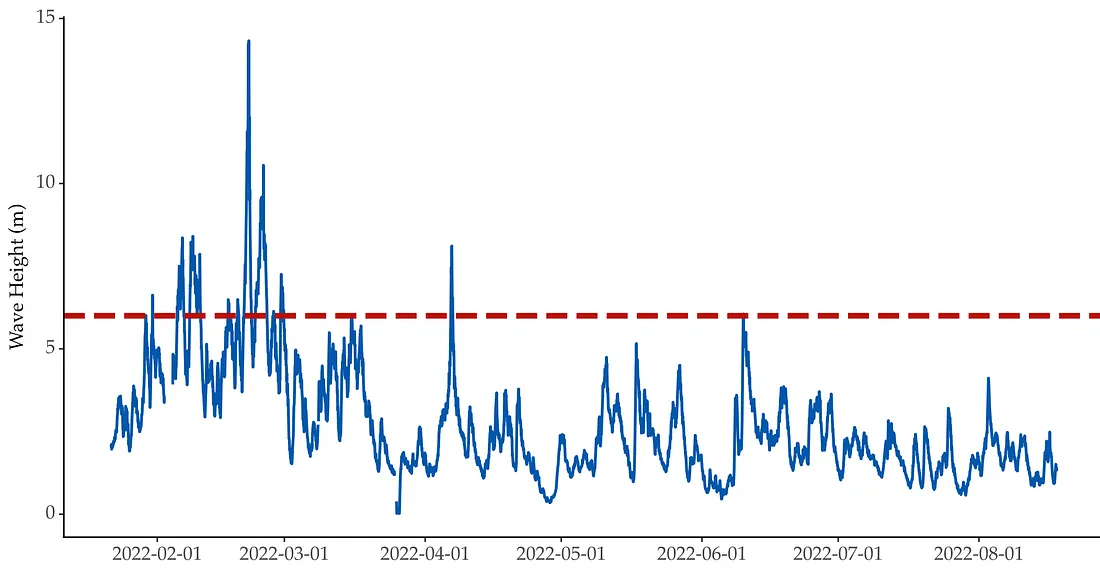</p> </center>

Hourly time series of the average height of ocean waves. The horizontal dashed line represents a critical safety threshold.

#### **Exceedance probability forecasting**
Our goal is to forecast the probability of a large wave, which we define as a wave above 6 meters. This problem is a particular instance of exceedance probability forecasting.

In a previous article, we explored the main challenges behind exceedance probability forecasting. Usually, this problem is tackled with one of two approaches:

1. A probabilistic binary classifier;
2. A forecasting ensemble. Probabilities are computed according to the ratio of models that forecast above the threshold.

Here, you’ll learn about a third approach. One which is based on a forecasting model, but which does not have to be an ensemble. Something like an ARIMA would do.

#### **Using the Cumulative Distribution Function**
Suppose that the forecasting model makes a prediction “y”. Then, also assume that this prediction follows a Normal distribution with a mean equal to “$y$”. Of course, the choice of distribution depends on the input data. Here we’ll stick with the Normal for simplicity. The standard deviation (“$s$”), under stationarity, can be estimated using the training data.

In our example, “$y$” is the height of the waves forecasted by the model. “$s$” is the standard deviation of the height of waves in the training data.

We get binary probabilistic predictions using the cumulative distribution function (CDF).

What is the CDF?

When evaluated at the value $x$, the CDF represents the probability that a random variable will take a value less than or equal to $x$. We can take the complementary probability (1 minus that probability) to get the probability that the random variable will exceed $x$.

<center> <p>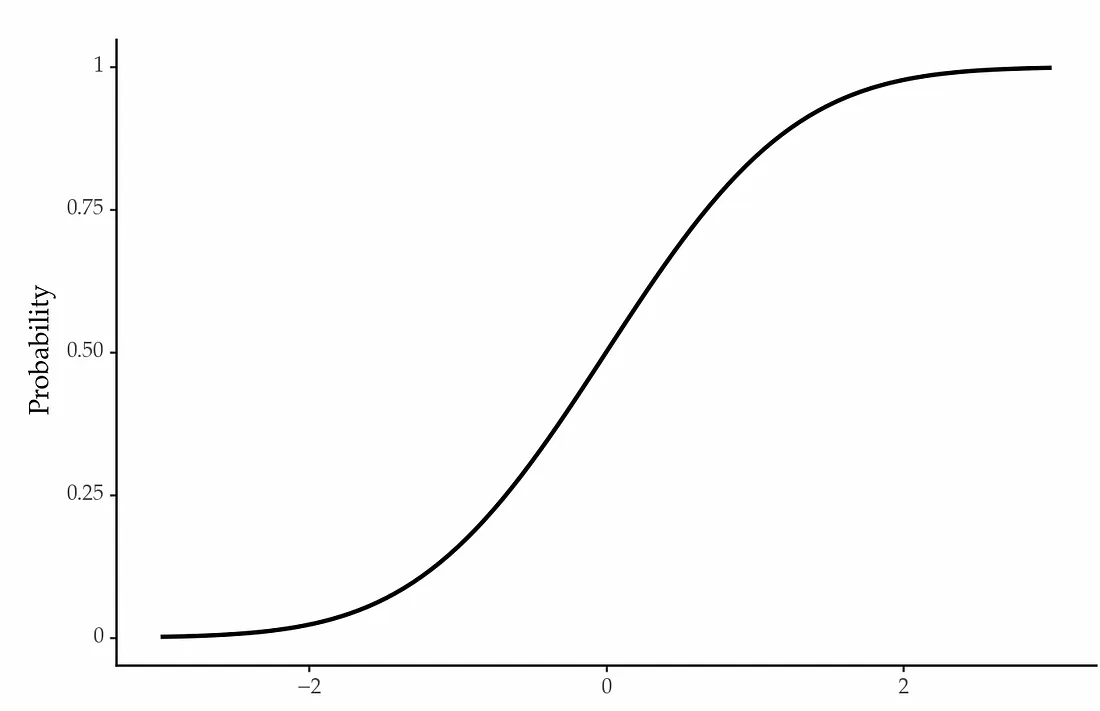</p> </center>

The cumulative distribution function for the standard Normal distribution.

In our case, x is the threshold of interest that denotes exceedance.

Here’s a snippet of how this can be done using Python:

In [2]:
import numpy as np
from scipy.stats import norm

# a random series from the uniform dist.
z = np.random.standard_normal(1000)
# estimating the standard dev.
s = z.std()

# fixing the exceedance threshold
# this is a domain dependent parameter
threshold = 1
# prediction for a given instant
yhat = 0.8

# probability that the actual value exceeds threshold
exceedance_prob = 1 - norm.cdf(threshold, loc=yhat, scale=s)

#### **Forecasting large waves**

Let’s see how we can use the CDF to estimate the probability of large waves.

First, we build a forecasting model using auto-regression.

In [4]:
import sys
sys.path.insert(0, '../')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from src.tde import time_delay_embedding

# using past 24 lags to forecast the next value
N_LAGS, HORIZON = 24, 1
# the threshold for large waves is 6 meters
THRESHOLD = 6

# train test split
train, test = train_test_split(series_hourly, test_size=0.2, shuffle=False)

# transforming the time series into a tabular format
X_train, Y_train = time_delay_embedding(train, n_lags=N_LAGS, horizon=HORIZON, return_Xy=True)
X_test, Y_test = time_delay_embedding(test, n_lags=N_LAGS, horizon=HORIZON, return_Xy=True)

# training a random forest
regression = RandomForestRegressor()
regression.fit(X_train, Y_train)

# getting point forecasts
point_forecasts = regression.predict(X_test)

Then, we can use the CDF to transform point forecasting into exceedance probabilities.

In [5]:
import numpy as np
from scipy.stats import norm

std = Y_train.std()

exceedance_prob = np.asarray([1 - norm.cdf(THRESHOLD, loc=x_, scale=std)
                            for x_ in point_forecasts])

The model is able to detect when large waves occur effectively:

<center> <p>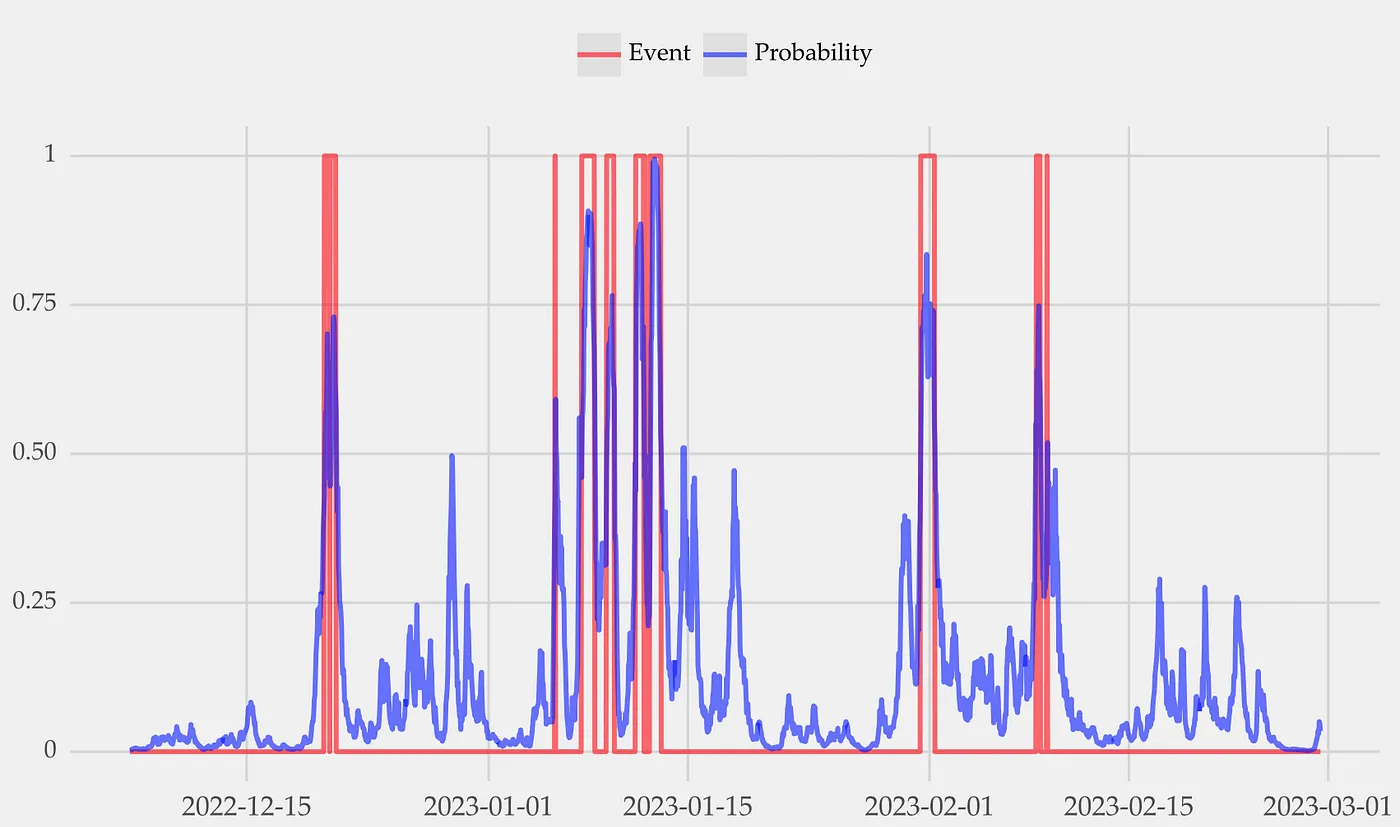</p> </center>

In a recent paper, I compared this approach with a classifier and an ensemble. The CDF-based method leads to better forecasts. You can check the paper in reference [2] for details. The code for the experiments is also available on Github.

#### **Key Takeaways**
- Getting binary probabilities from forecasting models is desirable. Especially in problems where point forecasts are also useful or the exceedance threshold changes;
- You can use a forecasting model to get binary exceedance probabilities using the CDF;
- Using the CDF is a competitive alternative to using a classifier or a regression ensemble.

Thank you for reading, and see you in the next story!

#### **References**
[1] Irish Wave Buoys (License: Creative Commons Attribution 4.0)

[2] Vitor Cerqueira, and Luis Torgo. “Exceedance Probability Forecasting via Regression for Significant Wave Height Forecasting.” arXiv preprint arXiv:2206.09821 (2022).